# Init

In [1]:
%%capture
%pip install ipython-autotime
%load_ext autotime
%pip install pandarallel
%pip install torch
%pip install torchvision
%pip install lightgbm xgboost catboost

time: 1min 51s (started: 2023-03-07 17:37:52 +00:00)


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import xarray as xr
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms
import statsmodels.api as sm

# Feature Engineering
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score


# Planetary Computer Tools
import pystac
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

import odc
from odc.stac import stac_load
from odc.algo import to_rgba

# Please pass your API key here
pc.settings.set_subscription_key('12006cf587a04113aab19bfd56909889')

# Others
import os
import random
import requests
import rich.table
from datetime import datetime, timedelta
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

import torch
torch.__version__

'1.13.1+cu117'

time: 12.9 s (started: 2023-03-07 17:39:44 +00:00)


In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

time: 6 ms (started: 2023-03-07 17:39:57 +00:00)


# Read Crop data

In [5]:
crop_yield_data = pd.read_csv("data/Crop_Yield_Data_challenge_2.csv")
crop_yield_data["Date of Harvest"] = pd.to_datetime(crop_yield_data["Date of Harvest"], format="%d-%m-%Y")
crop_yield_data.columns = ['District', 'Latitude', 'Longitude',
                           'Season',
                           'Intensity',
                           'HarvestDate',
                           'FieldSize', 
                           'RiceYield']
crop_yield_data

,District,Latitude,Longitude,Season,Intensity,HarvestDate,FieldSize,RiceYield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,2022-07-15,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,2022-07-15,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,2022-07-14,3.30,6400
...,...,...,...,...,...,...,...,...
552,Thoai_Son,10.364419,105.164984,WS,T,2022-04-12,7.80,6640
553,Thoai_Son,10.358094,105.189541,WS,T,2022-04-12,2.00,7200
554,Thoai_Son,10.368014,105.238516,WS,T,2022-04-12,6.20,7200
555,Thoai_Son,10.275419,105.234563,WS,T,2022-04-20,3.00,6400


time: 30.7 ms (started: 2023-03-07 17:39:57 +00:00)


In [6]:
test_df = pd.read_csv("data/Challenge_2_submission_template.csv").drop("ID No", axis=1)
test_df["Date of Harvest"] = pd.to_datetime(test_df["Date of Harvest"], format="%d-%m-%Y")
test_df.columns = ['District', 'Latitude', 'Longitude',
                           'Season',
                           'Intensity',
                           'HarvestDate',
                           'FieldSize', 
                           'RiceYield']
test_df

,District,Latitude,Longitude,Season,Intensity,HarvestDate,FieldSize,RiceYield
0,Chau_Phu,10.542192,105.187920,WS,T,2022-04-10,1.40,NaN
1,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN
2,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN
3,Chau_Phu,10.523520,105.138274,WS,D,2022-04-10,1.80,NaN
4,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN
...,...,...,...,...,...,...,...,...
95,Chau_Thanh,10.435839,105.132981,SA,D,2022-07-26,1.21,NaN
96,Chau_Phu,10.529357,105.147388,WS,T,2022-04-10,2.00,NaN
97,Chau_Thanh,10.452537,105.205118,SA,T,2022-07-20,5.50,NaN
98,Chau_Thanh,10.394341,105.126836,SA,T,2022-07-14,4.40,NaN


time: 23.9 ms (started: 2023-03-07 17:39:57 +00:00)


# Loading SITS data from API


## Search & Load items to Dataset 

In [7]:
RESOLUTION = 10 # meters per pixel
RESOLUTION_DEG = RESOLUTION / 111320.0 # resolution in degrees per pixel

def ha_to_deg(field_size):
    """
    Turn field size (ha) to deg
    """
    field_size_m2 = field_size*10000
    avg_edge = field_size_m2**(1/2)
    num_pixel = avg_edge/20
    return num_pixel*RESOLUTION_DEG
    

def search_pystac(bbox, time_window, collections):
    """
    Search for imagery items from planetarycomputer.microsoft.com
    Inputs:
        bbox: tuple(min_long, min_lat, max_long, max_lat)
        datetime: string"2021-12-01/2022-04-30"
        collections: list[catalog_name: string] ["sentinel-1-rtc", "sentinel-2-l2a"]
    Output:
        List[pystac.item.Item]
    """
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(collections=collections,
                         bbox=bbox,
                         datetime=time_window)

    items = search.get_all_items()    
    return items
    
    
def load_xds(items, bbox, bands):
    """
    Load data into xarray DataArray
    Inputs: 
        items: List[pystac.item.Item]
    Return:
        xds: xarray.Dataset
    """
    # Load data into xarray.Dataset
    xds = stac_load(items,
                    bbox=bbox,
                    bands=bands,
                    patch_url=pc.sign,
                    crs='EPSG:4326',
                    resolution=RESOLUTION_DEG,
                   )
    return xds


time: 1.01 ms (started: 2023-03-06 15:29:49 +00:00)


## Assign Vegetation Indexes

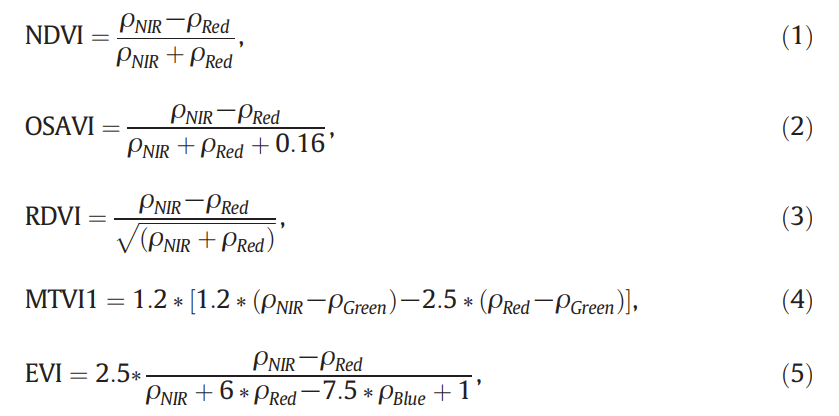
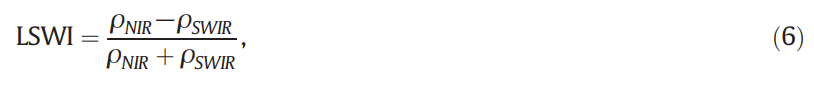

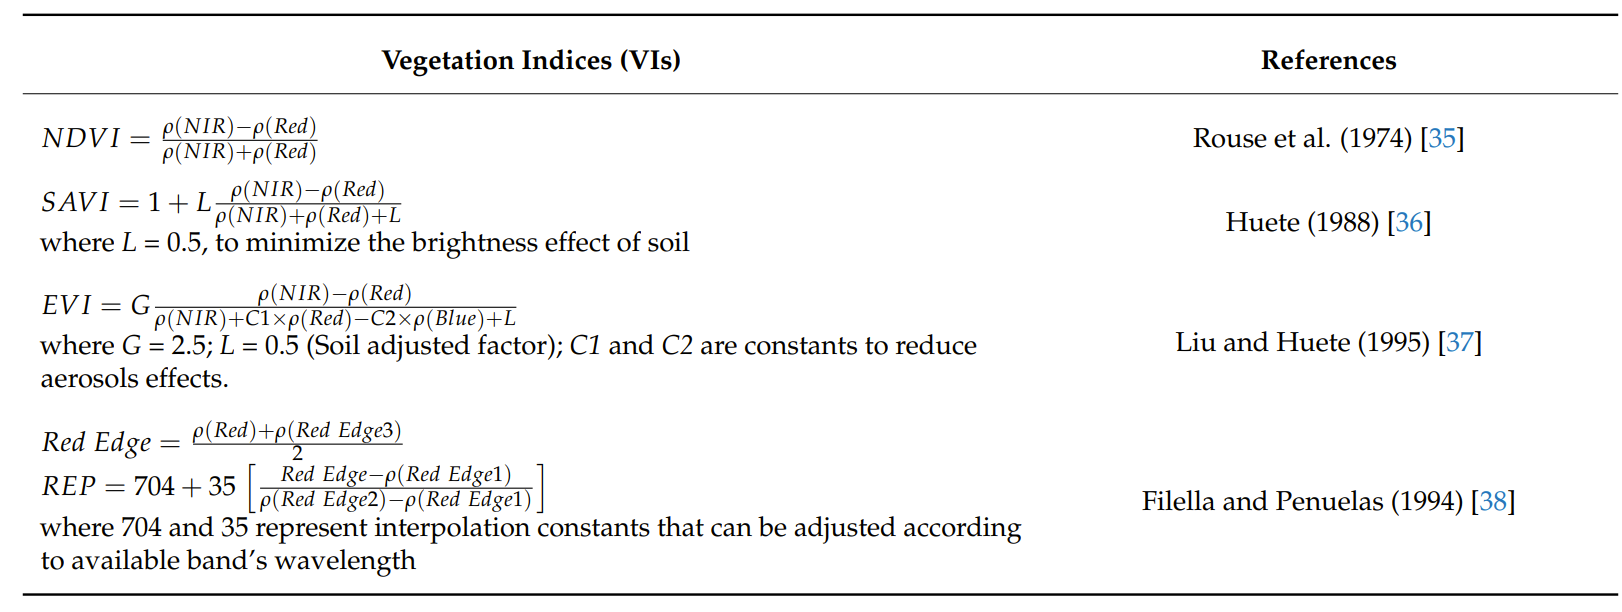

In [8]:
def assign_vis_1(xds):
    """
    Assign Vegetation Indexes for Sentinel 1 bands
    """
    # VV by VH: vv/vh
    xds = xds.assign(vv_by_vh=xds.vv/xds.vh)

    # VV add VH: vv + vh
    xds = xds.assign(vv_add_vh=xds.vv+xds.vh)

    # DOP (Degree of Polarization):
    xds = xds.assign(DOP=xds.vv/(xds.vv+xds.vh))
    
    # RVI (Radar Vegetation Index) : sqrt (1- VV / (VV+VH)) * 4 * (VH / (VV + VH))
    xds = xds.assign(RVI=(xds.DOP**(1/2))*4*(1-xds.DOP))

    return xds


def assign_vis_2(xds):
    """
    Assign Vegetation Indexes for Sentinel 2 bands
    """
    # Normalized Difference Vegetation Index (NDVI):
    xds = xds.assign(NDVI=(xds.nir-xds.red)/(xds.nir+xds.red))
    
    # Enhanced Vegetation Index (EVI):
    xds = xds.assign(EVI=2.5*(xds.nir-xds.red)/(xds.nir + 6*xds.red - 7.5*xds.blue + 1))
   
    # Soil Adjusted Vegetation Index (SAVI):
    L = 0.5
    xds = xds.assign(SAVI=(1+L)*(xds.nir-xds.red)/(xds.nir+xds.red+0.5))
    
    # Normalized Difference Water Index (NDWI): NDWI = (Green - SWIR) / (Green + SWIR)
    xds = xds.assign(NDWI=(xds.green-xds.B11)/(xds.green+xds.B11))
    
    # Moisture Stress Index (MSI): MSI = (SWIR - NIR) / (SWIR + NIR)
    xds = xds.assign(MSI=(xds.B11-xds.nir)/(xds.B11+xds.nir))
     
    # Chlorophyll Absorption Ratio Index (CARI): CARI = (R800 - R675) / (R800 + R675)
    xds = xds.assign(CARI=(xds.nir-xds.B05)/(xds.nir+xds.B05))

    return xds

time: 7.01 ms (started: 2023-03-06 15:29:49 +00:00)


## All-purpose Load xds function

In [18]:
[(datetime(2022, 3, 10) + timedelta(days=12)*i).date() for i in range(15)]

[datetime.date(2022, 3, 10),
 datetime.date(2022, 3, 22),
 datetime.date(2022, 4, 3),
 datetime.date(2022, 4, 15),
 datetime.date(2022, 4, 27),
 datetime.date(2022, 5, 9),
 datetime.date(2022, 5, 21),
 datetime.date(2022, 6, 2),
 datetime.date(2022, 6, 14),
 datetime.date(2022, 6, 26),
 datetime.date(2022, 7, 8),
 datetime.date(2022, 7, 20),
 datetime.date(2022, 8, 1),
 datetime.date(2022, 8, 13),
 datetime.date(2022, 8, 25)]

time: 4.11 ms (started: 2023-03-06 15:46:16 +00:00)


In [19]:
[(datetime(2021, 10, 29) + timedelta(days=12)*i).date() for i in range(17)]

[datetime.date(2021, 10, 29),
 datetime.date(2021, 11, 10),
 datetime.date(2021, 11, 22),
 datetime.date(2021, 12, 4),
 datetime.date(2021, 12, 16),
 datetime.date(2021, 12, 28),
 datetime.date(2022, 1, 9),
 datetime.date(2022, 1, 21),
 datetime.date(2022, 2, 2),
 datetime.date(2022, 2, 14),
 datetime.date(2022, 2, 26),
 datetime.date(2022, 3, 10),
 datetime.date(2022, 3, 22),
 datetime.date(2022, 4, 3),
 datetime.date(2022, 4, 15),
 datetime.date(2022, 4, 27),
 datetime.date(2022, 5, 9)]

time: 3.38 ms (started: 2023-03-06 15:46:27 +00:00)


In [25]:
def time_filtering(xds):
    if xds.Season == "SA":
        timeseries1 = [(datetime(2022, 3, 10) + timedelta(days=12)*i).date() for i in range(15)]
        timeseries2 = [(datetime(2022, 3, 11) + timedelta(days=12)*i).date() for i in range(15)]
    elif xds.Season == "WS":
        timeseries1 = [(datetime(2021, 10, 29) + timedelta(days=12)*i).date() for i in range(17)]
        timeseries2 = [(datetime(2021, 10, 30) + timedelta(days=12)*i).date() for i in range(17)]

    # Filter all timesteps in list above
    xds1 = xds.where(xds.time.dt.date.isin(timeseries1), drop=True)
    xds2 = xds.where(xds.time.dt.date.isin(timeseries2), drop=True)

    # Filter timeseries with 10 timesteps before harvest date
    xds1 = xds1.where(xds1.time >= xds1.coords['time'][-10], drop=True)
    xds2 = xds2.where(xds2.time >= xds2.coords['time'][-10], drop=True)

    # Change HarvestDate format from datetime to string -> can save
    xds1 = xds1.assign_attrs(HarvestDate=str(xds1.HarvestDate.date()))
    xds2 = xds2.assign_attrs(HarvestDate=str(xds2.HarvestDate.date()))

    return xds1, xds2


def get_sentinel_data(crop, sentinel=1, n_pixels=32):
    """
    Get Dataset from specific point (lat, long) of 1 field at season
    Return xds: xarray.Dataset
    """        
    # Get all data
    district, lat, long, season, intensity, harvest_date, field_size, rice_yield = crop[:8]

    # Surrounding box in degrees
    # deg = ha_to_deg(field_size)
    deg = RESOLUTION_DEG * (n_pixels/2)

    # Calculate the Lat-Lon bounding box region
    min_lat = lat - deg
    max_lat = lat + deg
    min_long = long - deg
    max_long = long + deg
    bbox = (min_long, min_lat, max_long, max_lat)

    # Define the time window
    # From 120 days (4 months) before HarvestDate => HarvestDate + time_cycle_days
    # SA: HarvestDate from 2022-07-05 to 2022-08-09
    # WS: HarvestDate from 2022-03-18 to 2022-04-22
    harvest_day = harvest_date.date()

    if sentinel == 1:
        time_cycle_days = 12
        bands = ['vv', 'vh']
        collections = ["sentinel-1-rtc"]        
        time_window = f"{harvest_day - timedelta(days=132)}/{harvest_day + timedelta(days=time_cycle_days)}"

    else:
        time_cycle_days = 5
        bands = ["red", "green", "blue", "nir", "B05", "B11", "SCL"]
        collections = ["sentinel-2-l2a"]
        time_window = f"{harvest_day - timedelta(days=120)}/{harvest_day + timedelta(days=time_cycle_days)}"
        

    # Search for item & Load data into xds: xarray.Dataset
    items = search_pystac(bbox, time_window, collections)    
    xds = load_xds(items, bbox, bands)

    # Crop lat, long to pixel
    xds = xds.where(xds.latitude >= xds.coords['latitude'][n_pixels-1], drop=True)
    xds = xds.where(xds.longitude <= xds.coords['longitude'][n_pixels-1], drop=True)

    # Add all metadata of crop to xds
    xds = xds.assign_attrs(crop[:8])
    
    if sentinel == 1:
        # Assign vegetation inedxes
        xds = assign_vis_1(xds)

        # Time Filtering for getting 10 timesteps before HarvestDate
        xds1, xds2 = time_filtering(xds)
        return xds1, xds2
    else:
        # Assign vegetation inedxes
        xds = assign_vis_2(xds)
        
        # Change HarvestDate format from datetime to string -> can save
        xds = xds.assign_attrs(HarvestDate=str(xds.HarvestDate.date()))
        return xds    


time: 3.8 ms (started: 2023-03-06 16:06:31 +00:00)


## Loading Sentinel 1


In [10]:
xds1, xds2 = get_sentinel_data(crop_yield_data.loc[0], sentinel=1, n_pixels=32)

time: 6.07 s (started: 2023-03-06 15:29:49 +00:00)


In [11]:
xds1

<xarray.Dataset>
Dimensions:      (time: 10, latitude: 32, longitude: 32)
Coordinates:
  * latitude     (latitude) float64 10.51 10.51 10.51 ... 10.51 10.51 10.51
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.2 105.2 105.2
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-03-22T22:46:05.287764 ... 2022-07...
Data variables:
    vv           (time, latitude, longitude) float32 0.1891 0.1372 ... 0.1759
    vh           (time, latitude, longitude) float32 0.1044 0.1016 ... 0.05138
    vv_by_vh     (time, latitude, longitude) float32 1.811 1.351 ... 5.976 3.424
    vv_add_vh    (time, latitude, longitude) float32 0.2936 0.2388 ... 0.2273
    DOP          (time, latitude, longitude) float32 0.6443 0.5746 ... 0.774
    RVI          (time, latitude, longitude) float32 1.142 1.29 ... 0.7954
Attributes:
    District:     Chau_Phu
    Latitude:     10.510542
    Longitude:    105.248554
    Season:       SA
    Intensity:    T
    HarvestDate:  2022-07-15
    FieldSize:    3.4
    RiceYield:    5500

time: 26.5 ms (started: 2023-03-06 15:29:55 +00:00)


In [12]:
xds2

<xarray.Dataset>
Dimensions:      (time: 10, latitude: 32, longitude: 32)
Coordinates:
  * latitude     (latitude) float64 10.51 10.51 10.51 ... 10.51 10.51 10.51
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.2 105.2 105.2
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-04-04T11:11:52.234391 ... 2022-07...
Data variables:
    vv           (time, latitude, longitude) float32 0.1148 0.123 ... 0.06355
    vh           (time, latitude, longitude) float32 0.05203 ... 0.009866
    vv_by_vh     (time, latitude, longitude) float32 2.206 2.742 ... 3.451 6.441
    vv_add_vh    (time, latitude, longitude) float32 0.1668 0.1678 ... 0.07342
    DOP          (time, latitude, longitude) float32 0.6881 0.7328 ... 0.8656
    RVI          (time, latitude, longitude) float32 1.035 0.915 ... 0.5001
Attributes:
    District:     Chau_Phu
    Latitude:     10.510542
    Longitude:    105.248554
    Season:       SA
    Intensity:    T
    HarvestDate:  2022-07-15
    FieldSize:    3.4
    RiceYield:    5500

time: 25.9 ms (started: 2023-03-06 15:29:55 +00:00)


## Loading Sentinel 2


In [13]:
xds = get_sentinel_data(crop_yield_data.loc[0], sentinel=2, n_pixels=32)
xds

<xarray.Dataset>
Dimensions:      (time: 24, latitude: 32, longitude: 32)
Coordinates:
  * latitude     (latitude) float64 10.51 10.51 10.51 ... 10.51 10.51 10.51
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.2 105.2 105.2
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-03-21T03:15:39.024000 ... 2022-07...
Data variables: (12/13)
    red          (time, latitude, longitude) float32 2.548e+03 ... 1.668e+03
    green        (time, latitude, longitude) float32 2.834e+03 ... 1.822e+03
    blue         (time, latitude, longitude) float32 2.61e+03 ... 1.438e+03
    nir          (time, latitude, longitude) float32 4.452e+03 ... 4.32e+03
    B05          (time, latitude, longitude) float32 3.247e+03 ... 2.518e+03
    B11          (time, latitude, longitude) float32 3.303e+03 ... 2.75e+03
    ...           ...
    NDVI         (time, latitude, longitude) float32 0.272 0.2756 ... 0.4429
    EVI          (time, latitude, longitude) float32 28.67 -14.18 ... 1.871
    SAVI         (time, latitude, longitude) float32 0.408 0.4134 ... 0.6643
    NDWI         (time, latitude, longitude) float32 -0.07642 ... -0.203
    MSI          (time, latitude, longitude) float32 -0.1482 -0.1571 ... -0.2221
    CARI         (time, latitude, longitude) float32 0.1565 0.1599 ... 0.2635
Attributes:
    District:     Chau_Phu
    Latitude:     10.510542
    Longitude:    105.248554
    Season:       SA
    Intensity:    T
    HarvestDate:  2022-07-15
    FieldSize:    3.4
    RiceYield:    5500

time: 12.5 s (started: 2023-03-06 15:29:56 +00:00)


# Write Xds to disk

In [7]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)
    
def read_xds(crop, path):
    # Open/Read Dataset from disk
    group = f"{crop.Latitude}_{crop.Longitude}_{crop.Season}"
    xds = xr.open_dataset(path, group=group)
    return xds

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time: 28.7 ms (started: 2023-03-07 17:39:57 +00:00)


In [8]:
SENTINEL1_TRAIN_PATH_1 = "data/updated/train_sentinel1_16px1.nc"
SENTINEL1_TRAIN_PATH_2 = "data/updated/train_sentinel1_16px2.nc"

SENTINEL1_TEST_PATH_1 = "data/updated/test_sentinel1_16px1.nc"
SENTINEL1_TEST_PATH_2 = "data/updated/test_sentinel1_16px2.nc"

SENTINEL2_TRAIN_PATH = "data/updated/train_sentinel2_16px.nc"
SENTINEL2_TEST_PATH = "data/updated/test_sentinel2_16px.nc"

time: 562 µs (started: 2023-03-07 17:39:57 +00:00)


## Write Sentinel 1 data

In [28]:
def load_save_sentinel1(crop_yield_data, path1, path2):
    def process_data(data):
        xds = get_sentinel_data(data, sentinel=1, n_pixels=16)
        return [xds]

    # Apply Parallel processing
    xds_list = crop_yield_data.parallel_apply(process_data, axis=1)
    xds_list = [xds for xdss in xds_list for xds in xdss[0]]
    print("Load XDataset successfully, total=", len(xds_list))
    
    # Save to disk
    print("Write XDataset")
    for idx, xds in tqdm(enumerate([x for x in xds_list]), total=len(xds_list)):
        group = f"{xds.Latitude}_{xds.Longitude}_{xds.Season}"
        if idx%2==0:
            xds.to_netcdf(path1, group=group, mode='a')
        else:
            xds.to_netcdf(path2, group=group, mode='a')

    return xds_list


time: 1.04 ms (started: 2023-03-06 16:06:37 +00:00)


In [ ]:
xds_list = load_save_sentinel1(crop_yield_data, 
                               path1=SENTINEL1_TRAIN_PATH_1, 
                               path2=SENTINEL1_TRAIN_PATH_2)

In [10]:
read_xds(crop_yield_data.loc[3], SENTINEL1_TRAIN_PATH_1)

<xarray.Dataset>
Dimensions:      (time: 10, latitude: 16, longitude: 16)
Coordinates:
  * latitude     (latitude) float64 10.5 10.5 10.5 10.49 ... 10.49 10.49 10.49
  * longitude    (longitude) float64 105.2 105.2 105.2 ... 105.2 105.2 105.2
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 2022-03-22T22:46:05.287764 ... 2022-07...
Data variables:
    vv           (time, latitude, longitude) float32 ...
    vh           (time, latitude, longitude) float32 ...
    vv_by_vh     (time, latitude, longitude) float32 ...
    vv_add_vh    (time, latitude, longitude) float32 ...
    DOP          (time, latitude, longitude) float32 ...
    RVI          (time, latitude, longitude) float32 ...
Attributes:
    District:     Chau_Phu
    Latitude:     10.494453
    Longitude:    105.241281
    Season:       SA
    Intensity:    T
    HarvestDate:  2022-07-15
    FieldSize:    4.3
    RiceYield:    6000

time: 8.07 s (started: 2023-03-07 17:40:22 +00:00)


## Write Sentinel 2 data

In [ ]:
def load_save_sentinel2(crop_yield_data, path):
    def process_data(data):
        xds = get_sentinel_data(data, sentinel=2, n_pixels=16)
        return [xds]

    # Apply Parallel processing
    xds_list = crop_yield_data.parallel_apply(process_data, axis=1)
    print("Load XDataset successfully, total=", len(xds_list))
    
    # Save to disk
    print("Write XDataset")
    for xds in tqdm([x[0] for x in xds_list]):
        group = f"{xds.Latitude}_{xds.Longitude}_{xds.Season}"
        xds.to_netcdf(path, group=group, mode='a')

    return True


In [ ]:
load_save_sentinel2(crop_yield_data, path=SENTINEL2_TRAIN_PATH)

Load XDataset successfully, total= 557
Write XDataset


 45%|████▍     | 249/557 [1:25:06<5:39:02, 66.05s/it]

In [41]:
read_xds(crop_yield_data.loc[556], SENTINEL2_TRAIN_PATH)

<xarray.Dataset>
Dimensions:      (time: 23, latitude: 16, longitude: 16)
Coordinates:
  * latitude     (latitude) float64 10.31 10.3 10.3 10.3 ... 10.3 10.3 10.3 10.3
  * longitude    (longitude) float64 105.3 105.3 105.3 ... 105.3 105.3 105.3
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 2021-12-16T03:21:41.024000 ... 2022-04...
Data variables: (12/13)
    red          (time, latitude, longitude) float32 ...
    green        (time, latitude, longitude) float32 ...
    blue         (time, latitude, longitude) float32 ...
    nir          (time, latitude, longitude) float32 ...
    B05          (time, latitude, longitude) float32 ...
    B11          (time, latitude, longitude) float32 ...
    ...           ...
    NDVI         (time, latitude, longitude) float32 ...
    EVI          (time, latitude, longitude) float32 ...
    SAVI         (time, latitude, longitude) float32 ...
    NDWI         (time, latitude, longitude) float32 ...
    MSI          (time, latitude, longitude) float32 ...
    CARI         (time, latitude, longitude) float32 ...
Attributes:
    District:     Thoai_Son
    Latitude:     10.304295
    Longitude:    105.27046
    Season:       WS
    Intensity:    T
    HarvestDate:  2022-04-13
    FieldSize:    2.3
    RiceYield:    7200

time: 35.8 ms (started: 2023-03-07 01:53:21 +00:00)


In [42]:
load_save_sentinel2(test_df, path=SENTINEL2_TEST_PATH)

Load XDataset successfully, total= 100
Write XDataset


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


True

time: 6min 12s (started: 2023-03-07 01:53:24 +00:00)
